In [17]:
from typing import Tuple, TypeVar
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gpflow
from gpflow.utilities import print_summary
import sys
sys.path.append('..')
from utils.utilities import (HMCParameters,create_mala_mcmc, load_single_gene_normalized, create_data, load_data, load_single_gene, load_filtered_data, create_standard_mcmc, create_trcd_model, create_premRNA_model,
                       optimize_with_scipy_optimizer, optimize_premRNA, fit_rbf, predict_trcd,
                       plot_trcd_predict, plot_premRNA_predict, select_parameters, optimize_premRNA, init_hyperparameters)

from utils.utils_mcmc import (run_mcmc, run_mala, analyse_samples, experiment_print, reset_parameters)
import pymc3
from typing import Callable, List, TypeVar
from trcd.utils import SamplingHelper
gpflow.config.set_default_float(np.float64)  

Scalar = TypeVar("Scalar", tf.Tensor, float)
FullData = Tuple[tf.Tensor, tf.Tensor]
Observations = Tuple[tf.Tensor, tf.Tensor, tf.Tensor]

np.random.seed(100)
tf.random.set_seed(100)

def compute_half_life(D):
    return np.log(2)/D




## Load the data

In [7]:
data1 = pd.read_csv('../data/LB_GP_TS.csv', sep=",")
data2 = pd.read_csv('../data/Exon_intron_counts_data_normalizedbylibrarydepthonly_20200120.txt',sep=" ")
names_transcripts =  pd.read_csv('../data/zygotic_tr_95_genes.csv', sep=";")

t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))
rep_no = 3
t = np.hstack((t0,t0,t0))[:,None]
t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))

## The gene we are interested in

In [8]:
'''
Gene and transcripts id
'''
gene_id = 'FBgn0000395'
tr_id = 'FBtr0071610'


In [9]:
data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id)

## Normalized data

mRNA per cell: 269.21; mRNA per TS 40.36; embryo age 175. 

In [10]:
norm_m = 269.21
norm_p = 40.36
time_indexes = np.array([np.where(t == 160)[0],np.where(t == 175)[0],np.where(t == 190)[0]]).flatten()

In [11]:
data, observations, gene_id, data_p, observations_p = load_single_gene_normalized(gene_id, tr_id, time_indexes, norm_m, norm_p)

In [12]:
#data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id, time_indexes, norm_m, norm_p)
data_orig, observations_orig, gene_id_orig, data_p_orig, observations_p_orig = load_single_gene(gene_id, tr_id)

## Create and optimize the model

In [13]:
# Choose initial hyperparameters (if no good guess, multiple restrats with grid search recommended)
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

# Create the model
trcd, dict_parameters = create_trcd_model(data, initial_lengthscale, initial_variance, initial_S, transform_base=None)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=None)  # When `names` is None, same dictionary is returned.

# Assign initial values
trcd.model.kernel.D.assign(0.4)

# Choose parameters of the model to be optimized
dict_parameters = select_parameters(dict_parameters,
                                    names=['D','S', 'variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=725.842065507428
Step 10 loss=657.4085171579526


In [14]:
# print estimates of the parameters
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │        value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   0.00348989 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │              │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   4.19178    │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ TRCD.model.kernel.vari

### half-life

In [15]:
compute_half_life(np.asarray(trcd.model.kernel.D.value()))

198.61570131881342

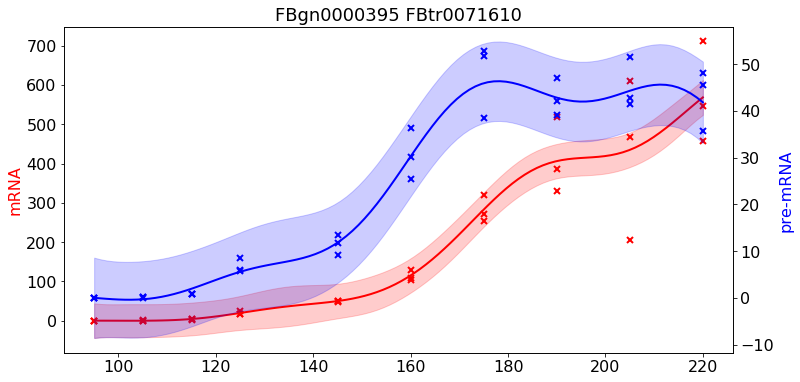

In [16]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations, variance_m, variance_p)

### Run MCMC

In [12]:
parameters = list(dict_parameters.values())

# [Step 0] Run MCMC
# [Step 0] Save results at 'mcmc results mala'
0.001
0.001
     parameter acceptance_rate
0            D         0.99996
1            S         0.99996
2     variance         0.99996
3  lengthscale         0.99996
4   variance_m         0.99996
5   variance_p         0.99996


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


     parameter                 MAP                   hpd_l  \
0            D                 0.0  3.8013583995506672e-06   
1            S  30.757211787714837      2.8929019016913586   
2     variance   53.81262324227237        51.6996965714498   
3  lengthscale                 0.0      15.184928677056345   
4   variance_m  214.82868659415976       196.6454160684009   
5   variance_p   8.821099542570654       6.605150763478153   

                 hpd_u  
0  0.11249848977202312  
1   27.491782808355637  
2    54.40345828256317  
3   18.498394001724474  
4   207.36292663548184  
5    9.350832980932973  
# [Step 0] MCMC finished
# [Step 1] Run MCMC
# [Step 1] Save results at 'mcmc results mala'
0.07
0.07
     parameter acceptance_rate
0            D             0.0
1            S             0.0
2     variance             0.0
3  lengthscale             0.0
4   variance_m             0.0
5   variance_p             0.0
     parameter                 MAP               hpd_l               hp

/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


# [Step 1] MCMC finished
# [Step 2] Run MCMC
# [Step 2] Save results at 'mcmc results mala'
0.05
0.05
     parameter acceptance_rate
0            D             0.0
1            S             0.0
2     variance             0.0
3  lengthscale             0.0
4   variance_m             0.0
5   variance_p             0.0
     parameter                 MAP               hpd_l               hpd_u
0            D                 0.0  0.6931471805599453  0.6931471805599453
1            S  30.757211787714837   28.09585350297736   28.09585350297736
2     variance   53.81262324227237  53.243054129499846  53.243054129499846
3  lengthscale                 0.0  0.6931844152500405  0.6931844152500405
4   variance_m  214.82868659415976  201.71280202678008  201.71280202678008
5   variance_p   8.821099542570654   8.178405616166478   8.178405616166478


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


# [Step 2] MCMC finished
# [Step 3] Run MCMC
# [Step 3] Save results at 'mcmc results mala'
0.1
0.1
     parameter acceptance_rate
0            D             0.0
1            S             0.0
2     variance             0.0
3  lengthscale             0.0
4   variance_m             0.0
5   variance_p             0.0
     parameter                 MAP               hpd_l               hpd_u
0            D                 0.0  0.6931494433630809  0.6931494433630809
1            S  30.757211787714837  29.303253326291884  29.303253326291884
2     variance   53.81262324227237   53.04697955245961   53.04697955245961
3  lengthscale                 0.0   10.19370432847805   10.19370432847805
4   variance_m  214.82868659415976   201.6009473290915   201.6009473290915
5   variance_p   8.821099542570654   8.237548018792127   8.237548018792127


/Users/Yuliya/opt/anaconda3/envs/gpflow2new/lib/python3.6/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


# [Step 3] MCMC finished


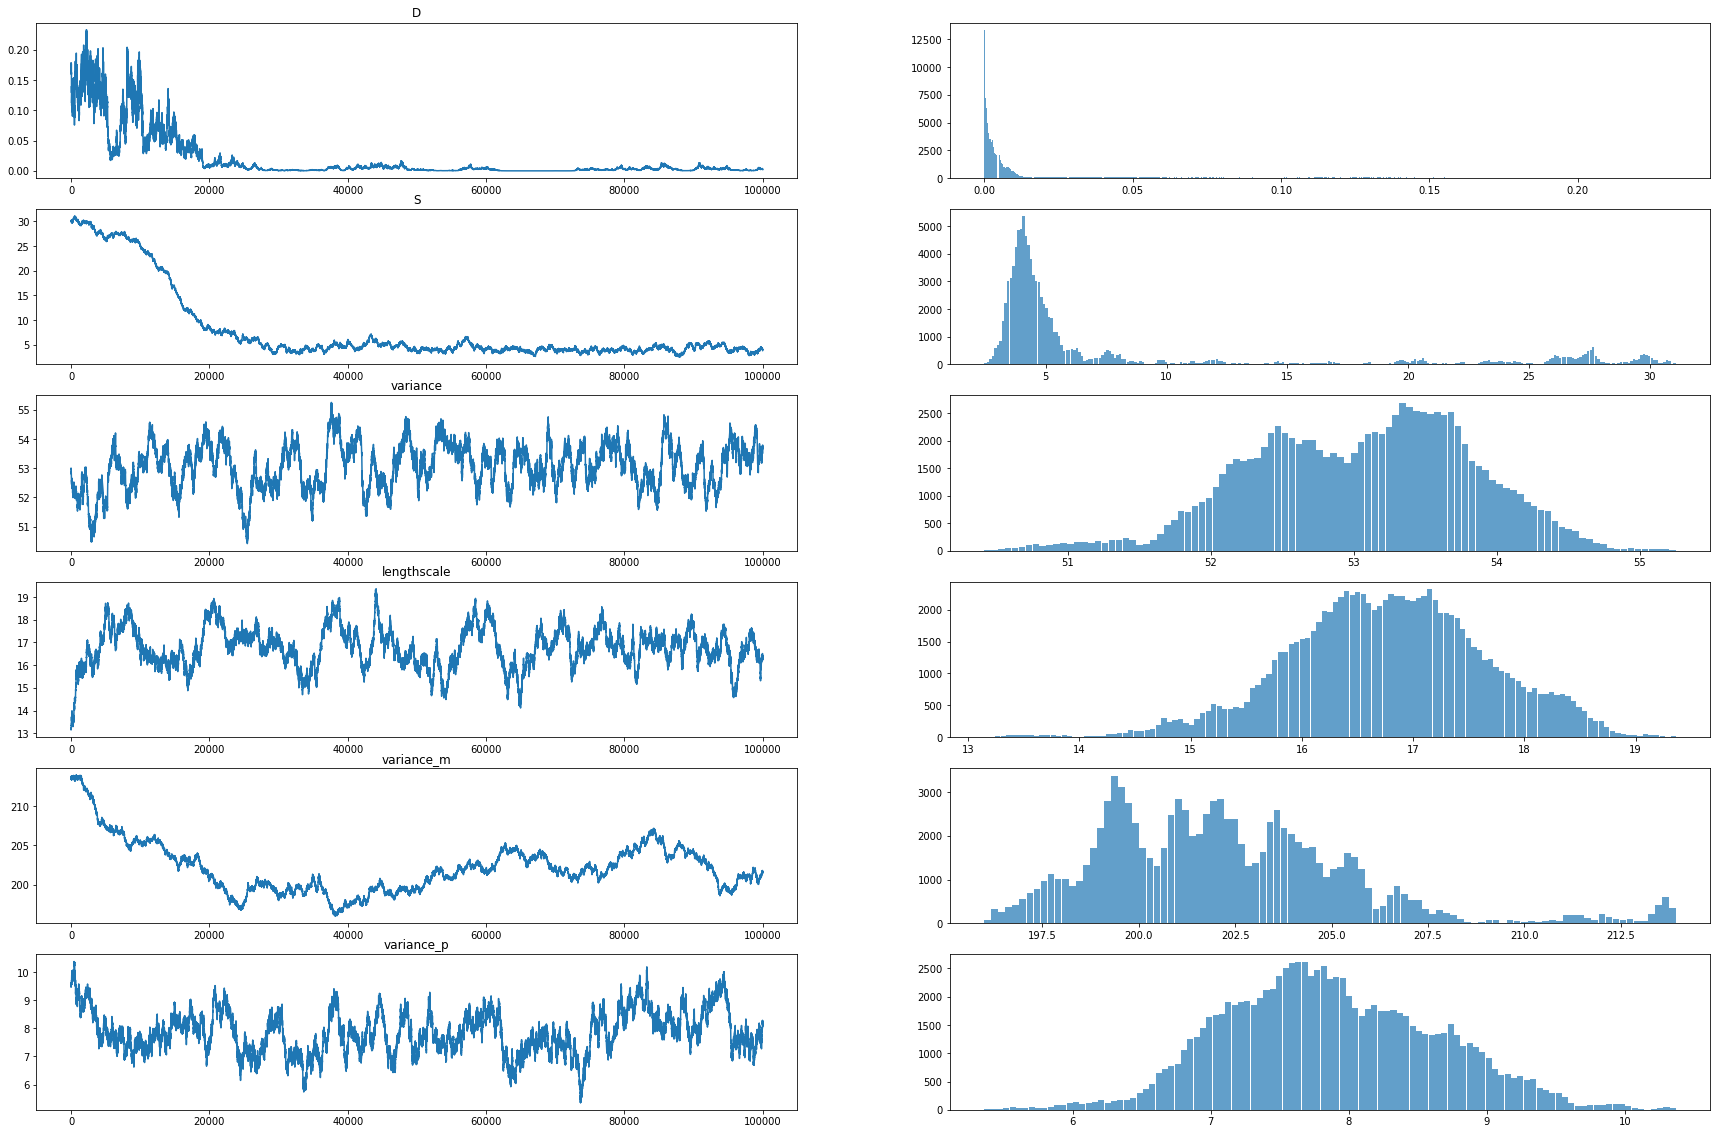

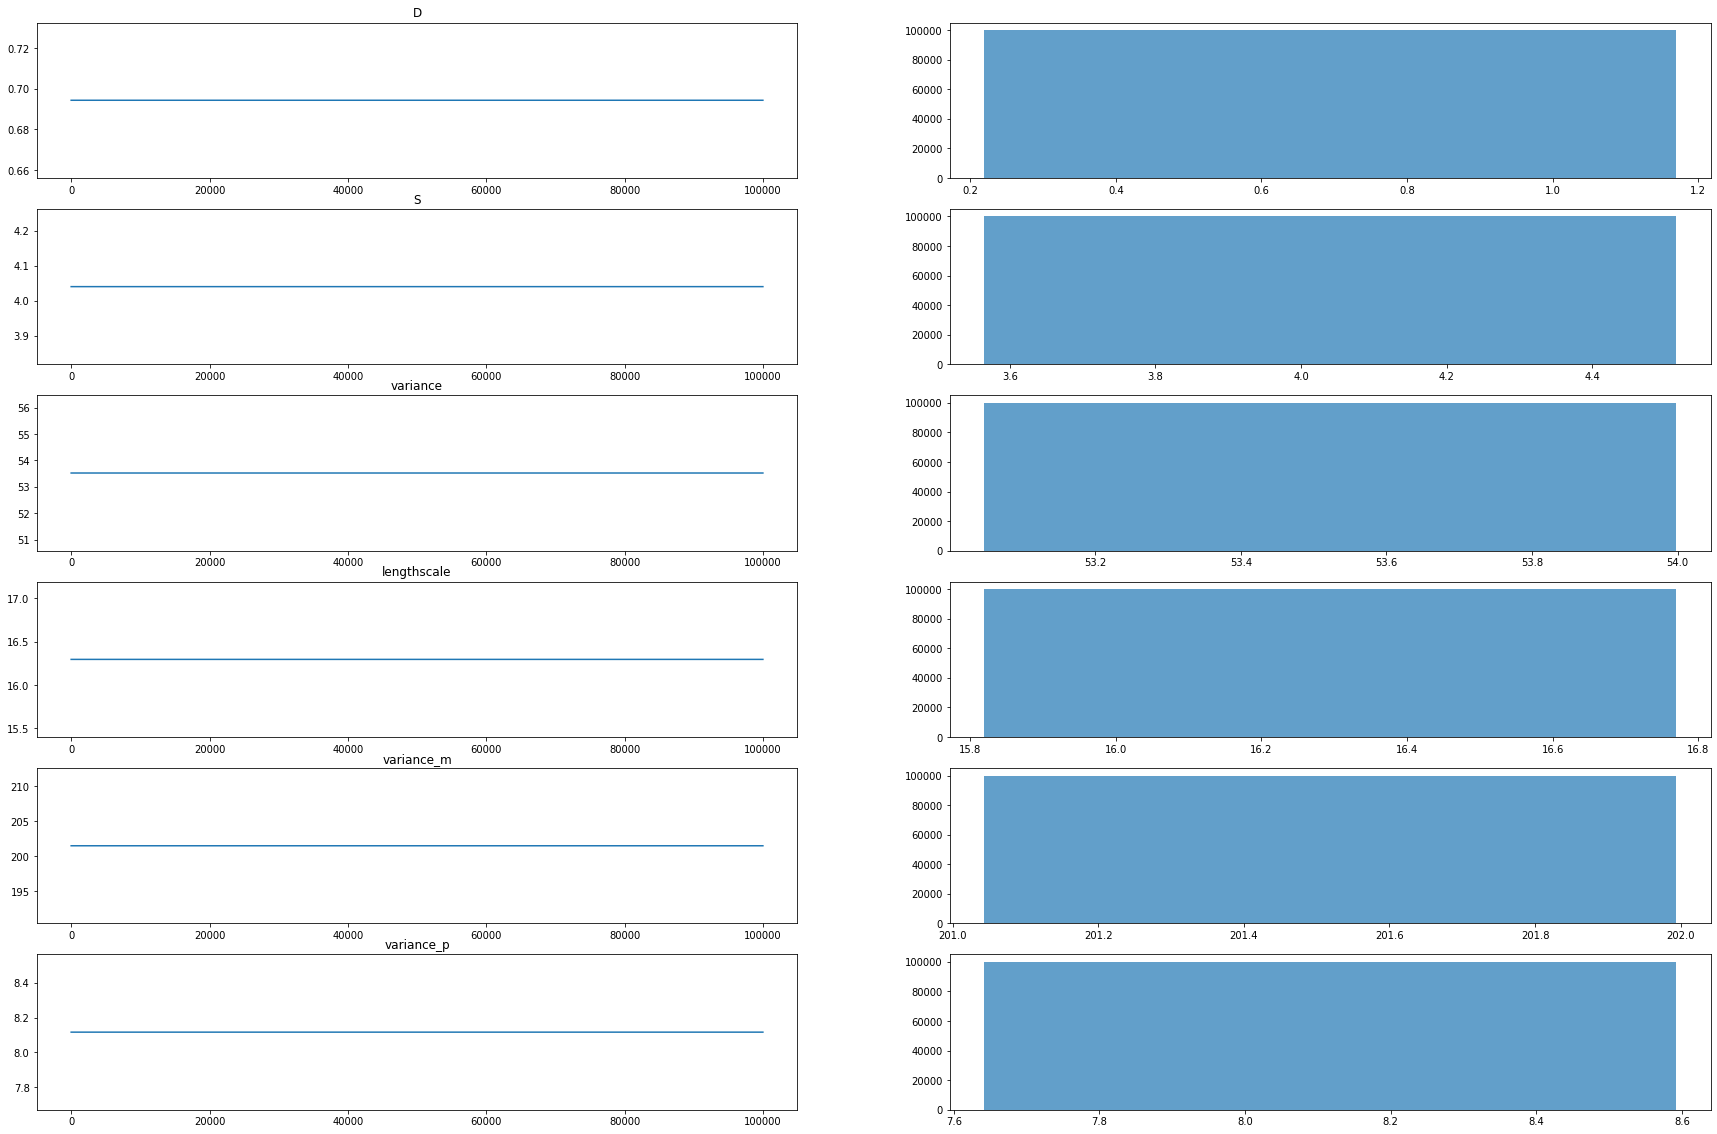

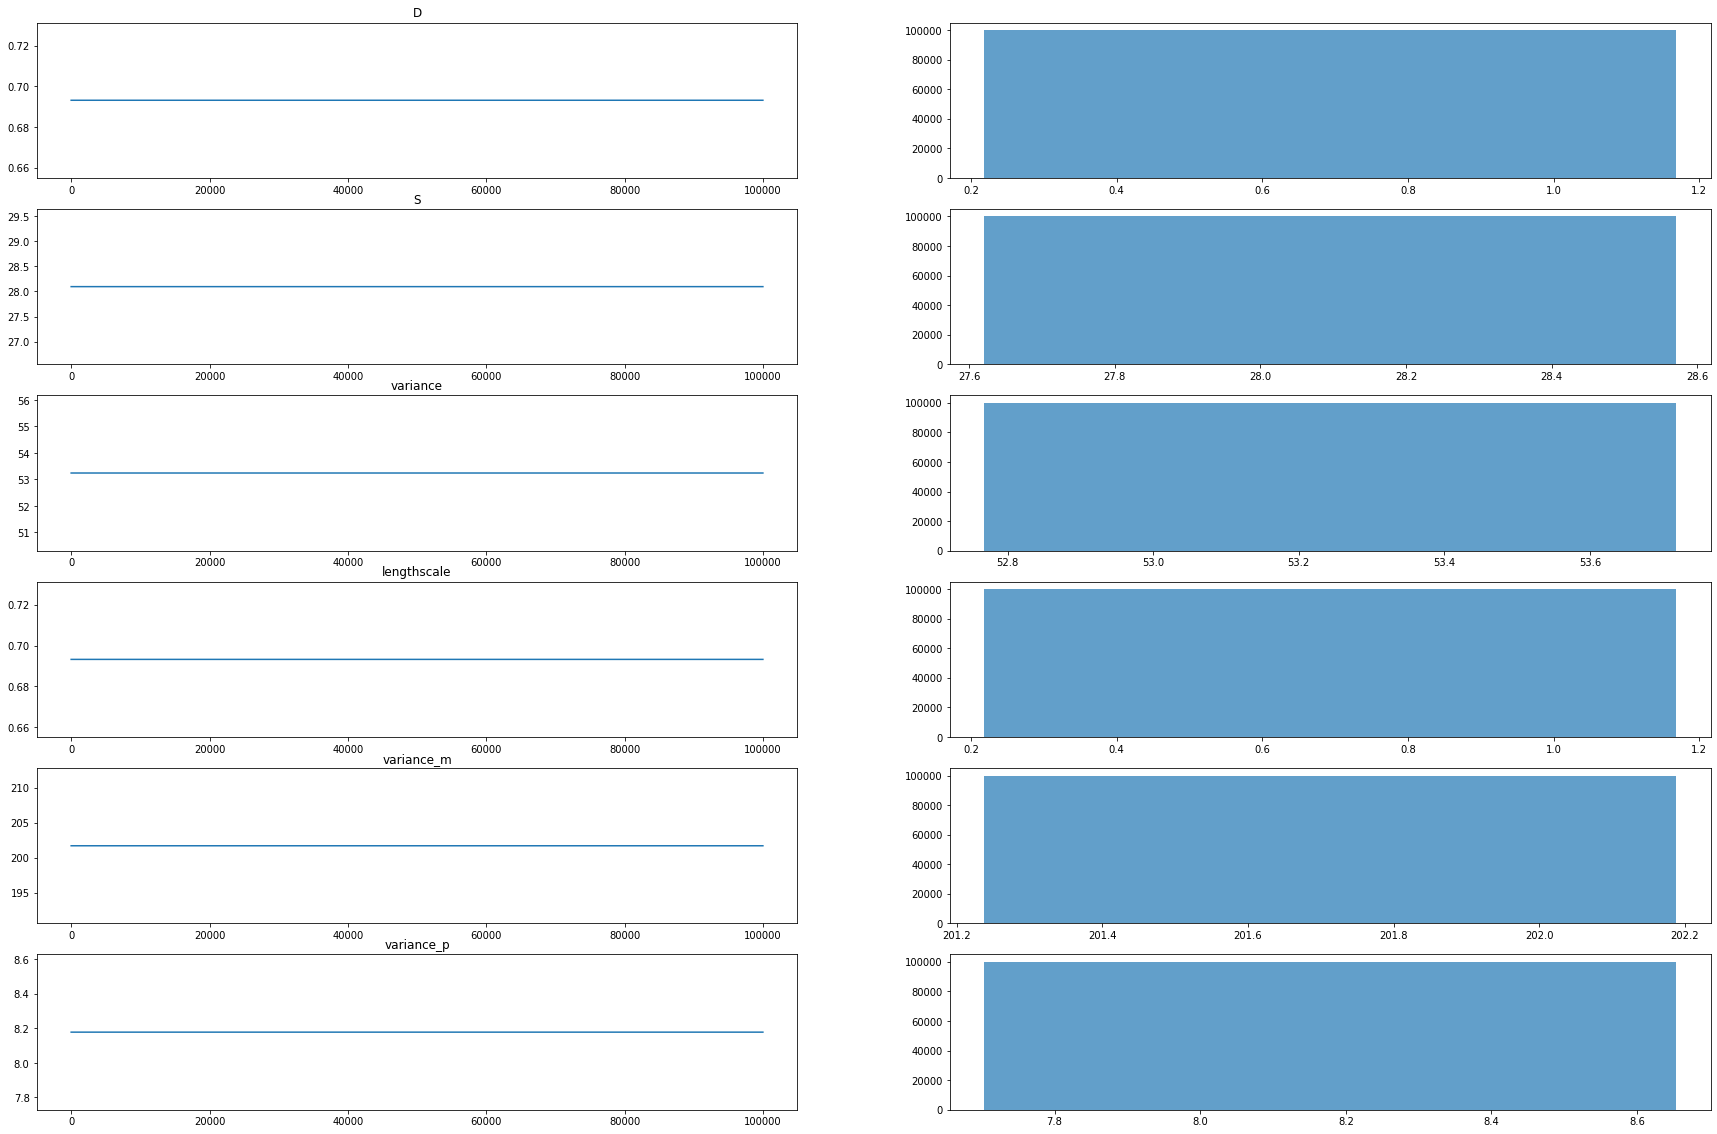

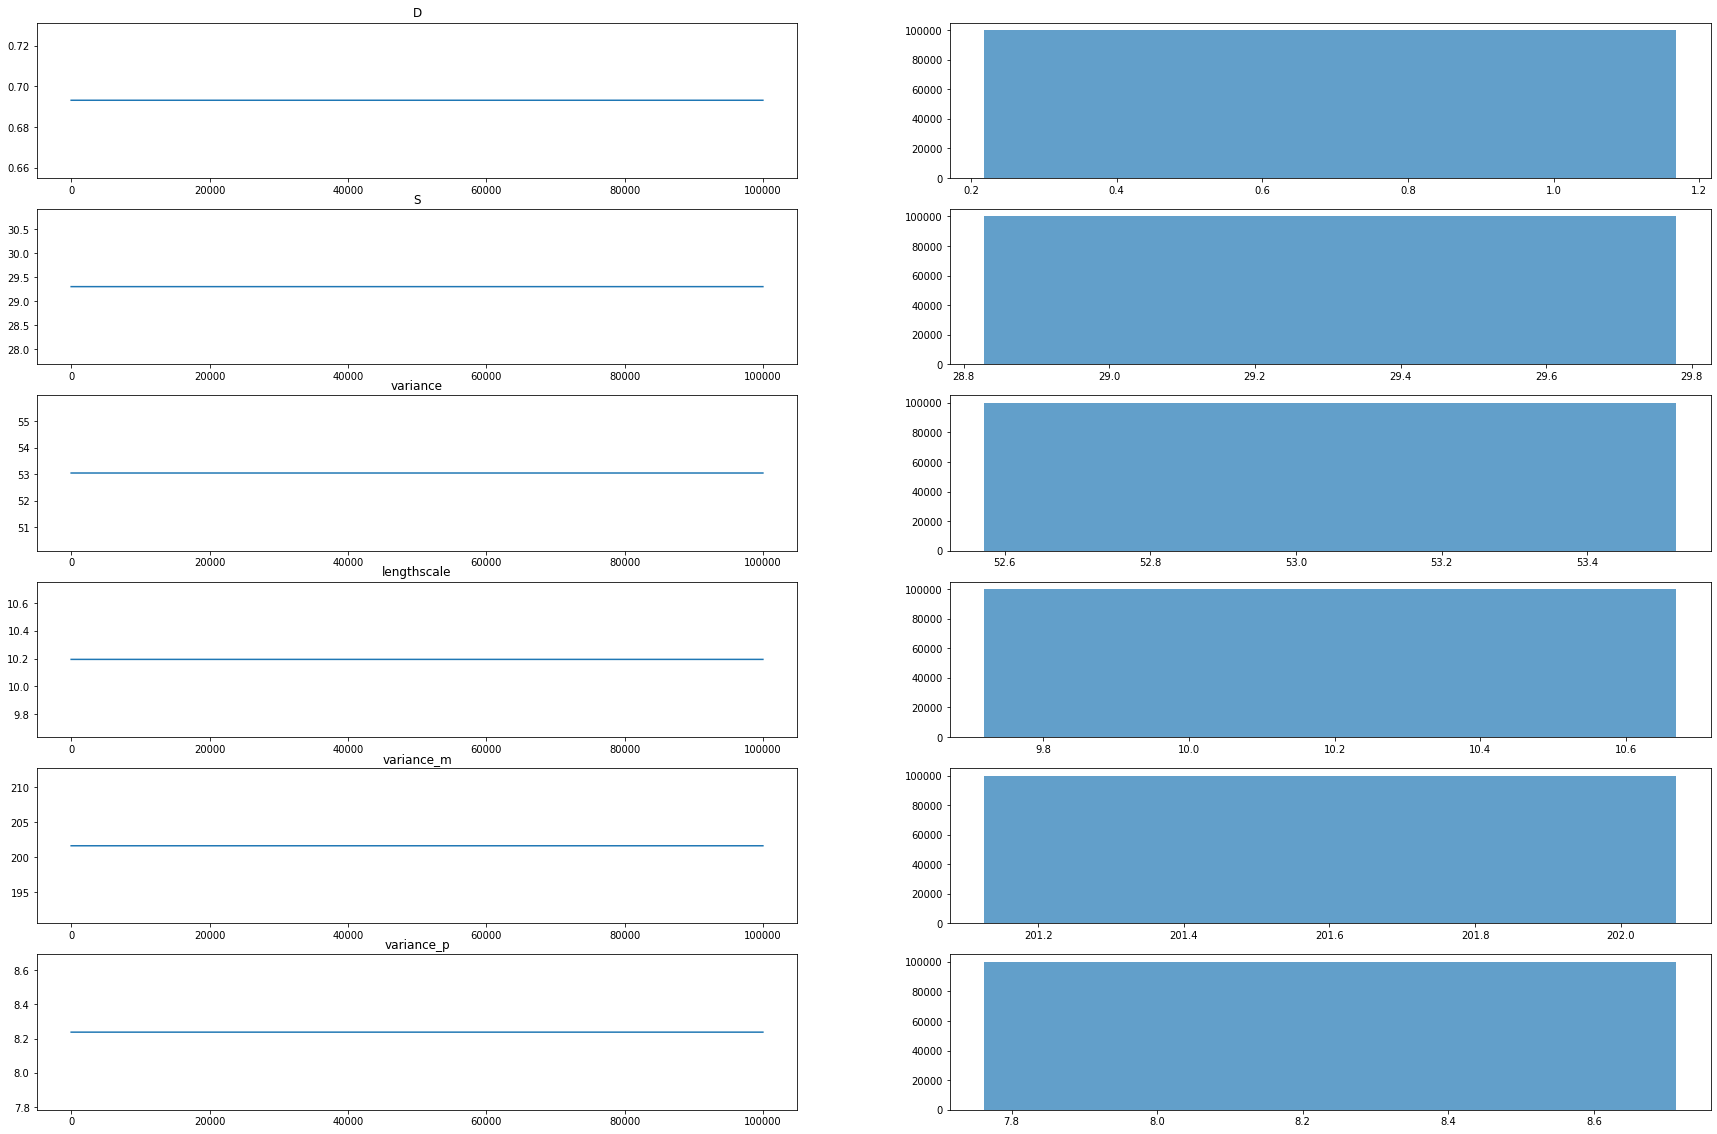

In [19]:
np.random.seed(100)
tf.random.set_seed(100)
from pathlib import Path
parameters_vector = tf.stack(parameters)
hmc_parameters = HMCParameters(num_samples=1000, num_burnin_steps=1000)
hmc_helper, run_chain = create_mala_mcmc(trcd, parameters, hmc_parameters)
gpflow.config.set_default_positive_minimum(1e-6)
#step_size_mala = np.array([ 10**-5 , 10**-4 , 10**-3 , 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 1])
step_size_mala = np.array([ 0.001 , 0.07 , 0.05,  0.1 ])
for j in range(step_size_mala.shape[0]):
    step_size = step_size_mala[j]
    #pathname = f"different gene results mala-{step_size}"
    try:
        experiment_print(j, "Run MCMC")
        step_size = step_size_mala[j]
        #num_leapfrog, step_size = leapfrog_num_and_step_size[j]
        pathname = f"mcmc results mala"
        experiment_print(j, f"Save results at '{pathname}'")

        samples = run_mala(run_chain,
                               hmc_helper,
                               step_size=step_size_mala[j])
        analyse_samples(gene_id, tr_id, parameters_vector, step_size, *samples, dict_parameters=dict_parameters, pathname=pathname)
            #reset_parameters(parameters, initial_values)
        experiment_print(j, f"MCMC finished")
    except:
        print('Experiment error')

### half-life HPD

In [22]:
np.log(2)/np.asarray(0.0000)

inf

In [23]:
np.log(2)/np.asarray(0.000535)

1295.6022066541034

## Original data

In [12]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data_orig, initial_lengthscale, initial_variance, initial_S, transform_base=None)
dict_parameters = select_parameters(dict_parameters,
                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=330.27169711734416
Step 10 loss=277.71556301722626


In [13]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  0.00830484 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │             │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │  0.347364   │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ TRCD.model.kernel.variance    

### half-life

In [15]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

83.46305237093313

predicted y failed, predicted f


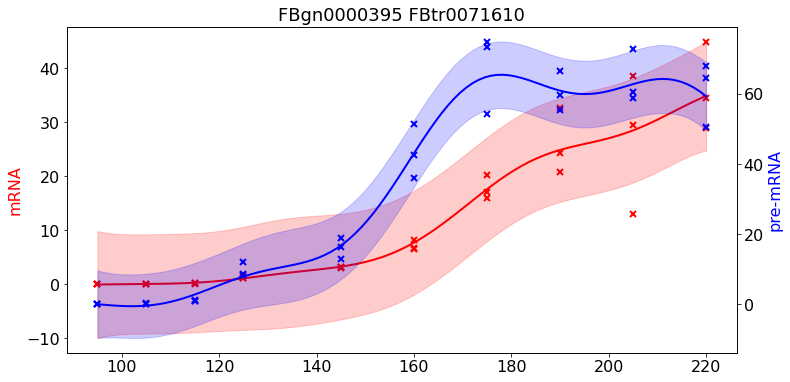

In [16]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations_orig, variance_m, variance_p)

### Run MCMC

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('results_mala_processed/hpdFBgn0000395_FBtr0071610.csv')

In [7]:
df

,Unnamed: 0,Unnamed: 0.1,parameter,MAP,hpd_l,hpd_u
0,0,0,D,0.0082,0.0000,0.0243
1,1,1,S,0.3494,0.1802,0.6170
2,2,2,variance,75.5462,73.3316,77.7743
3,3,3,lengthscale,17.2303,15.4306,19.3331
4,4,4,variance_m,8.8298,7.8884,9.8127
5,5,5,variance_p,17.4548,16.1085,18.9171


### half-life HPD

In [25]:
np.log(2)/np.asarray(0.0000)

inf

In [24]:
np.log(2)/np.asarray(0.0243)

28.524575331684993